In [1]:
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers
import iminuit,probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

In [4]:
def plot_hist(df, column = 'energy', binning = 20, title = "Energy plot", output = False, fill = True, label = 'default', x_label = 'energy (MeV)', range = 0, log = True, data = False, save = False, save_dir = ''):
    '''
    Print a histogram of energy from our dataframe,.
    '''
    # for simplicity/readability, scoop out the relevant columns from the pandas dataframe.
    energy_vals = df[column].to_numpy()

    if (range==0):
        range = (np.min(energy_vals), np.max(energy_vals))

    # control viewing of hist
    if (fill == True):
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, range = range)
    else:
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, histtype='step', linewidth = 2, range = range)
    plt.title(title)
    plt.ylabel("events")
    plt.xlabel(x_label)
    if log == True:
        plt.yscale('log')
    if (save==True):
        if not (save_dir == ''):
            plt.savefig(save_dir + title + ".png")
        else:
            print("Please provide a suitable directory to save the data!")
    if (output==True):
        plt.show()
    if (data==True):
        return (cnts, edges, patches)
    else:
        return


def load_data(folder_path):
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # NOTE Break this section up, its annoying like this.
    dfs = []
    df_trs = []
    df_ems = []
    i = 0
    end = len(file_names)
    # create massive dataframe with all of them
    for file in file_names:
        file_path = folder_path + file
        df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
        dfs.append(df)
        # include MC particles (boooo takes ages)

        # collecting the correct components of the file, not exactly sure how this works
        df_ps = pd.read_hdf(file_path, 'MC/particles')
        #df_ps = df_ps[df_ps.creator_proc == 'conv']
        # collecting event map
        df_em = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
        df_trs.append(df_ps)
        df_ems.append(df_em)
        i += 1

        if (i%50 == 0):
            print(i)

    tracks = pd.concat(dfs, axis=0, ignore_index=True)

    particles = pd.concat(df_trs, ignore_index=True)
    particles['event_id'] = particles['event_id'] * 2   # double it

    eventmap = pd.concat([dt for dt in df_ems])
    # create particle list also

    return (tracks, particles, eventmap)

def cut_effic(df1, df2, verbose = False):
    '''
    Prints efficiency of cuts for singular cut
    df1 -> cut df
    df2 -> initial df
    '''
    length_1 = df1['event'].nunique()
    length_2 = df2['event'].nunique()
    efficiency = ((length_1/length_2)*100)
    print("Efficiency: {:.2f} %".format(efficiency))

    if (verbose == True):
        print(("Events in reduced dataframe: {}\nEvents in initial dataframe: {}").format(len(df1), len(df2)))

    return efficiency


def fiducial_track_cut_2(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    '''
    Produces fiducial track cuts while removing all events that have outer fiducial tracks
    '''
    # create lists of outer_fiduc entries
    z_df_low = df[(df['z_min'] <= lower_z)]
    z_df_up = df[(df['z_max'] >= upper_z)]
    r_df = df[(df['r_max'] >= r_lim)]

    # scrape the events
    low_list = (z_df_low['event'].to_numpy())
    up_list = (z_df_up['event'].to_numpy())
    r_list = (r_df['event'].to_numpy())

    # apply the filter to remove all events that fall in outer fiduc
    df1 = df[~df['event'].isin(low_list)]
    df2 = df1[~df1['event'].isin(up_list)]
    df3 = df2[~df2['event'].isin(r_list)]

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))


    return df3




def one_track_cuts(df, verbose = False):
    '''
    Remove events with more than one track
    THERE IS A COLUMN WITH THIS INFO IN IT, CALCULATING IT IS UNNECESSARY
    '''
    # 1-track event counter
    event_counts = df.groupby('event').size()
    #print(event_counts[:5]) # showing that you see how many 
                            #  trackIDs there are per event
    one_track = event_counts[event_counts == 1].index

    # filter dataframe
    one_track_events = df[df['event'].isin(one_track)]
    

    if (verbose == True):
        print("Removing events with more than one track.")
        print("Events with one track: {}".format(one_track))
        display(one_track_events.head())
    

    return one_track_events




def overlapping_cuts(df, verbose = False):
    '''
    Remove all events with energy overlap != 0
    '''

    ovlp_remove = df[df['ovlp_blob_energy']==0]

    if (verbose==True):
        print("Removing overlapping blobs...")

    return ovlp_remove




def energy_cuts(df, lower_e = 1.5, upper_e = 1.7, verbose = False):
    '''
    Apply cuts around the relevant energy
    '''
    filt_e_df = df[(df['energy'] >= lower_e) & (df['energy'] <= upper_e)]

    if (verbose == True):
        print("Cutting energy events around {} & {} keV".format(lower_e, upper_e))

    return filt_e_df


def remove_low_E_events(df, energy_limit = 0.05):
    '''
    Remove low energy tracks, add their energy back to the first
    track and then update 'numb_of_tracks' to be up to date
    '''

    tracks_test = df.copy(deep=True)

    # take events with lower than 50 keV, 0.05 MeV
    condition = (tracks_test.energy < energy_limit)
    summed_df = tracks_test[condition].groupby('event')['energy'].sum().reset_index()

     # merge these as a new column
    merged_df = pd.merge(tracks_test, summed_df, on='event', suffixes=('', '_sum'), how = 'left').fillna(0)
    # add this summed energy to first column
    merged_df['energy'] = merged_df.apply(lambda row: (row['energy'] + row['energy_sum']) if row.name == merged_df[merged_df['event'] == row['event']].index[0] else row['energy'], axis=1)

    # drop energy sum column
    result_df = merged_df.drop('energy_sum', axis = 1)

    # then remove all tracks below the energy threshold
    condition_upper = (result_df.energy > energy_limit)
    remove_low_E = result_df[condition_upper]

    # count the number of events identified with unique event, and change numb_of_tracks to reflect this
    event_counts = remove_low_E['event'].value_counts(sort = False)

    # apply this to numb_of_tracks
    remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)

    return remove_low_E


def len_events(df):
    '''
    Returns the number of unique events as len(df) doesn't work in this case
    '''
    length_1 = df['event'].nunique()
    return length_1


def positron_scraper(data_path, save = False):
    """
    Function that iterates over files with MC and collects only positron events.
    Intended to reduce the memory resources of MC data.
    """



     # collect all filenames
    try:
        file_names = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
    except:
        print("File path incorrect, please state the correct file path\n(but not any particular folder!)")


    # read in a singular file to collect the column titles
    
    MC_df_single = pd.read_hdf(data_path + file_names[0], 'MC/particles')

    MC_df = []
    pos_df = pd.DataFrame(columns = MC_df_single.columns)
    eventmap = []


    i = 0
    

    # how much you chunk your data
    chunker = np.floor(len(file_names)*0.1)

    # chunk file_names
    
    for file in file_names:
        file_path = data_path + file

        # load in file
        MC_df_temp = pd.read_hdf(file_path, 'MC/particles')
        MC_df.append(MC_df_temp)
        eventmap.append(mcio.load_eventnumbermap(file_path).set_index('nexus_evt'))


        i += 1

        # chunk checker, every time you hit a certain chunk,
        # collect the positron events and wipe the df
        if ((i%chunker) == 0):
            print("Chunking at event {}!".format(i))
            # concat the list
            MC_df = pd.concat(MC_df, axis = 0, ignore_index = True)
            #print("Post concat")
            #display(MC_df)
            pos_data = MC_df[MC_df['particle_name'] == 'e+']

            
            #display(pos_data)
            #print(type(pos_data))
            # collect positron events into df
            pos_df = pos_df.append(pos_data)
            print("{} positron events found\n{} positron events total".format(pos_data.shape[0],pos_df.shape[0]))
            #display(pos_df)

            # make space
            MC_df = []

    if (save == True):
        pos_df.to_hdf('positrons.h5', key = 'pos', mode = 'w')

    return pos_df


def blob_positron_plot(ecut_rel, ecut_no_positron_df, save = False, save_title = 'plot.png'):
    '''
    Plots the blob energies with and without positrons.
    '''

    # the original way
    plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    #plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
    #plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

    plot_hist(ecut_no_positron_df, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_no_positron_df, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    plt.legend()

    if (save == True):
        plt.savefig(save_title)
    plt.show()


def true_fom_calc(p_data, no_p_data, cut_list, verbose = False):
    '''
    produces a figure of merit list based
    on cuts to specific categories and their
    consequent fits

    '''

    # create deep copies for safety
    pos_data = p_data.copy(deep = True)
    no_pos_data = no_p_data.copy(deep = True)

    if (verbose == True):
        blob_positron_plot(pos_data, no_pos_data)
    # Take the initial, no blob2 cut values for ns and nb
    ns0 = len(pos_data.index)
    nb0 = len(no_pos_data.index)
    # create all the lists for fom
    e = []
    b = []
    fom = []

    for i in range(len(cut_list)):
        
        # remove blob 2 values below value on cut_list
        pos_data = pos_data[(pos_data['eblob2'] > cut_list[i])]
        no_pos_data = no_pos_data[(no_pos_data['eblob2'] > cut_list[i])]


        # apply fit to the new data 
        if (verbose == True):
            print("Signal events: {}\nBackground events: {}\n FOM: {}".format())
        
        # collect number of signal events vs number of backgrounds, which you know 
        ns = len(pos_data.index)
        nb = len(no_pos_data.index)

        # produce fom value
        e.append(ns/ns0)
        b.append(nb/nb0)
        fom.append(e[i]/np.sqrt(b[i]))

        if (verbose == True):
            blob_positron_plot(pos_data, no_pos_data)
        
    # that should be it? i dont expect this to work first time, but lets test it!
    return fom

def load_file(file_path):
    tracks = dstio.load_dst(file_path, 'Tracking', 'Tracks')
    # include MC particles (boooo takes ages)

    # collecting the correct components of the file, not exactly sure how this works
    particles = pd.read_hdf(file_path, 'MC/particles')
    #df_ps = df_ps[df_ps.creator_proc == 'conv']
    # collecting event map
    eventmap = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')

    return (tracks, particles, eventmap)



In [6]:
folder_path = '../Isaura_full_reco_work/data/isaura_test/'

data = load_data(folder_path)

tracks = data[0]
particles = data[1]
eventmap = data[2]

50
100
150
200
250
300


In [9]:
display(tracks)
print(tracks.columns)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080004,0,0.474018,33.900984,6,3204,3,15.675,-319.325,149.169202,...,153.759638,22.762342,-289.535819,154.954336,0.368737,0.314440,0.209227,14.111111,13.875000,11.455763
1,5080004,1,0.002621,0.000000,1,107,3,72.675,-308.325,151.912540,...,154.619509,77.678952,-303.919042,154.619509,0.002621,0.002621,0.002621,14.111111,13.875000,11.455763
2,5080004,2,0.000310,0.000000,1,16,3,-23.325,-243.325,154.748278,...,154.748278,-21.554647,-241.886992,154.748278,0.000310,0.000310,0.000310,14.111111,13.875000,11.455763
3,5080006,0,0.274218,41.565404,13,4025,3,77.675,446.675,717.947738,...,745.884040,111.194348,462.682357,721.697907,0.118426,0.101983,0.006987,14.545455,14.642857,14.844206
4,5080006,1,0.105549,14.545455,2,971,3,19.675,298.675,339.278625,...,344.631064,35.388069,302.841707,343.998794,0.105549,0.105549,0.105549,14.545455,14.642857,14.844206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155960,4060706,3,0.000792,20.897176,2,47,5,331.675,375.675,376.758080,...,376.758080,347.619732,378.049330,382.498692,0.000599,0.000420,0.000227,14.702703,14.850000,13.879979
155961,4060706,4,0.000218,0.000000,1,16,5,301.675,300.675,385.581000,...,385.581000,303.390768,302.119110,385.581000,0.000218,0.000218,0.000218,14.702703,14.850000,13.879979
155962,4060710,0,0.568012,68.571429,32,8501,1,298.675,274.675,522.659780,...,529.078580,333.898970,280.813202,525.604814,0.141785,0.041648,0.000000,14.200000,13.714286,14.432458
155963,4060712,0,0.894838,102.202468,49,7767,2,-9.325,407.675,332.916150,...,343.656648,18.091208,472.788680,414.211251,0.593538,0.083403,0.000000,14.714286,14.625000,12.914461


Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min',
       'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave',
       'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y',
       'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y',
       'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x',
       'vox_size_y', 'vox_size_z'],
      dtype='object')


Max Z value: 1203.3753375000001


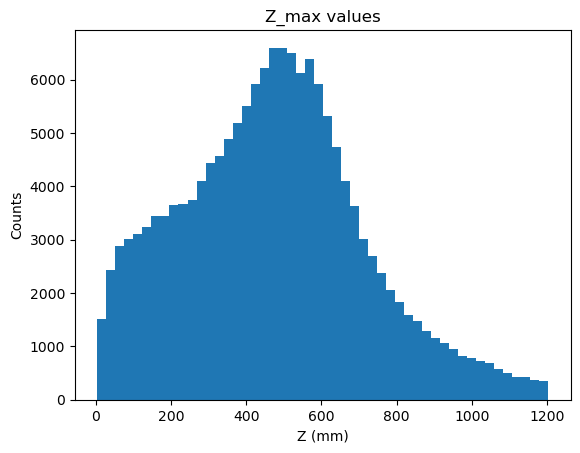

In [15]:
plt.hist(tracks['z_max'], bins = 50)
plt.title("Z_max values")
plt.xlabel("Z (mm)")
plt.ylabel("Counts")
print("Max Z value: {}".format(np.max(tracks['z_max'])))